# **!! WARNING !!**

Work in progress! This notebook doesn't function as intended at the time of writing this comment!

# Fit a binary model to your event from Day 4 class

Here we will show you how to fit a binary model to your planetary event.

## Load packages

In [2]:
import os,sys
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.parallax import parallax

from pyLIMA.fits import LM_fit
from pyLIMA.models import PSPL_model, USBL_model
from pyLIMA.models import pyLIMA_fancy_parameters

from pyLIMA.outputs import pyLIMA_plots

import multiprocessing as mul

%matplotlib widget

## pyLIMA vs MulensModel

In this excersise, you will learn how to use the [**pyLIMA package**](https://github.com/ebachelet/pyLIMA) to fit a binary microlensing event.

First let's load the data.

## Load data

Use the same event (number) you have used during the class.

In [6]:
##########################
# Put in your number here
my_number = 1
##########################
data = np.loadtxt('../data/roman_w146_%02d.dat'%my_number)

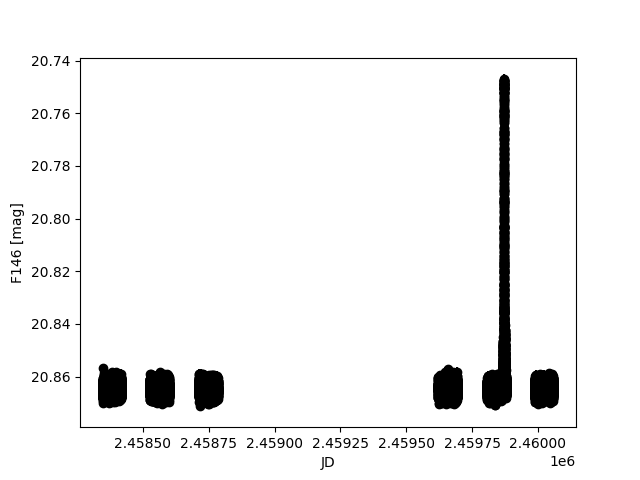

In [7]:
## Lets have a look at the data
fig = plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], marker='o', color='black', ls='');
plt.gca().invert_yaxis();
plt.xlabel('JD');
plt.ylabel('F146 [mag]');

## First we will set up the event

This is similar to MulensModel. If we would like to fit with the parallax model, we would also have to specify the coordinates of the event when we define it like this:

`my_event = event.Event(ra=Right Ascension of the event, dec=Declination of the event)`.

In our case, however, we will not fit parallax.

In [8]:
my_event = event.Event(ra=0.1, dec=0.1)
my_event.name = 'Simulated_Roman_event_%02d'%my_number

## Then we will add the data

We will use the `telescope` class to do that. We will not include the parallax effect, but if you'd like, we explain how to specify if your observatory is on Earth or in Space.

If you have a mix of ground- and space based observatories and include parallax , you can specify the observatory's location by the `location` key word. The Roman observatory is located in space (hence `Space` value for that key word). The `space_craft` name would indicate the spacecraft's name that **`pyLIMA`** recognizes and knows how to translate to the [**JPL Horizon**](https://ssd.jpl.nasa.gov/)'s spacecraft code. In this case, however, the code for Roman doesn't exist yet. We will therfore use the L2 point as the best proxy.

In [9]:
telescope = telescopes.Telescope(name='Roman',
                                 lightcurve=data,
                                 lightcurve_names=['time','mag','err_mag'],
                                 lightcurve_units=['JD','mag','mag'],
                                #  location = 'Space', spacecraft_name = 'L2'
                                 )

my_event.telescopes.append(telescope)

Before we set up the model, lets put in the parameters you found using the analytical equations.

In [10]:
t_0 = 2459750.
u_0 = 0.8
t_E = 10.
rho = 0.1
s = 1
q = 0.001
alpha = 1.67

# We will also need some parameters in log_10, because
# it's easier to probe their parameter space that way
log_t_E = np.log10(t_E)
log_rho = np.log10(rho)
log_s = np.log10(s)
log_q = np.log10(q)

Now we will set up the model. We will probe the time scale $t_E$, source radius $\rho$, separation $s$, and mass ratio $q$ in log space. This way, we will be able to probe the parameter space more efficiently. To do that in **`pyLIMA`**, we will use the `pyLIMA_fancy_parameters` function.

In [11]:
fancy = pyLIMA_fancy_parameters.StandardFancyParameters()

We can now set up the model. We will use the uniform source-binary lens model (USBL), and we will force **`pyLIMA`** to not fit parallax. To do that, we will specify the `parallax` keyword. The first one relates to the type of parallax effect we want to fit: in our case, it's `None`. Other options are Full, `Annual`, or `Terrestrial`, when dealing with space-based (first one), or ground-based observatories only (last two). When fitting parallax, we also have to specify the $t_{0,\text{par}}$ parameter, like in **`MulensModel`**. In our case, we will set it to 0. In case you'd like to fit parallax, you should choose one close to the time of closest approach, $t_0$.

In [12]:
usbl = USBL_model.USBLmodel(my_event, fancy_parameters=fancy, parallax=['None', 0.])

Finally, we can set up our fitting method. `pyLIMA` ofers several different methods. We will use one of the fastest ones, `LM_fit` which is an implementation of [**Levenberg-Marquardt algorithm**](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm).

Other options you could use are:
- `TRF_fit` - [**Trust Region**](https://en.wikipedia.org/wiki/Trust_region) Reflective algorithm;
- `DE_fit` - a [**Differential Evolution**](https://en.wikipedia.org/wiki/Differential_evolution) algorithm to optimize our parameters (here more about [**the implementation in scipy**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html), which **`pyLIMA`** uses);
- `MCMC_fit` - a [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) method, using [**`emcee` package**](https://emcee.readthedocs.io/en/stable/).

Words of caution: `DE_fit` and `MCMC_fit` probe the parameter space, and will take consideribly longer than `LM_fit` and `TRF_fit`.

In [13]:
lm_fit = LM_fit.LMfit(usbl)

We will also use the fruits of your hard work! Instead of starting with a set of random parameters, we will use parameters that you found earlier to start our search.

In [20]:
# parameters: t_0, u_0, log(t_E), log(rho), log(s), log(q), alpha, pi_EN, pi_EE,
lm_fit.model_parameters_guess = [t_0, u_0, log_t_E,
                                 log_rho, log_s, log_q,
                                 alpha
                                 ]

We also need to set up boundries for our parameter space. For now, edit the `t_start` and `t_end` parameters to reflect the time when the events are happening. You can leave the other parameter bounries as is.

In [21]:
t_start = 2459740.
t_end = 2460000.

#Boundries
lm_fit.fit_parameters['t0'][1] = [t_start, t_end]
lm_fit.fit_parameters['u0'][1] = [0., 1.]
lm_fit.fit_parameters['log_tE'][1] = [-1., 3.]
lm_fit.fit_parameters['log_rho'][1] = [-4., 1.]
lm_fit.fit_parameters['log_separation'][1] = [-3., 1.]
lm_fit.fit_parameters['log_mass_ratio'][1] = [-5., 1.]
lm_fit.fit_parameters['alpha'][1] = [0.0, 2.*np.pi]

lm_fit.priors_parameters['t0'][1] = [t_start, t_end]
lm_fit.priors_parameters['u0'][1] = [0., 1.]
lm_fit.priors_parameters['log_tE'][1] = [-1., 3.]
lm_fit.priors_parameters['log_rho'][1] = [-4., 1.]
lm_fit.priors_parameters['log_separation'][1] = [-3., 1.]
lm_fit.priors_parameters['log_mass_ratio'][1] = [-5., 1.]
lm_fit.priors_parameters['alpha'][1] = [0.0, 2.*np.pi]

Finally, we can run our optimizer. This will take a while!

In [ ]:
lm_fit.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459750.0, 0.8, 1.0, -1.0, 0.0, -3.0, 1.67, 229.1543189203579, 0.0]


Let's display our output. You will also see a couple of files appearing in the directory, which contain the results of your fit, that you can use for an analysis!

Does the model fit well?

In [ ]:
lm_fit.fit_outputs(bokeh_plot=True)